# Transfer learning on a binary image classification

**In this notebook, I use feature extraction to create a classification model for pictures of dogs and cats. I use EfficientNetB0 as my base model**

In [ ]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from imageio.v2 import imread
import tensorflow as tf
tf.random.set_seed(42) # Global seed for random number generator

## Load and explore data

In [ ]:
train_dir = "./data/cat_dog/train"
test_dir = "./data/cat_dog/test"

In [ ]:
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 224, 224, 3

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          batch_size=32)

Found 32 files belonging to 2 classes.


In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                         image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          batch_size=32)

Found 32 files belonging to 2 classes.


In [ ]:
class_names = train_data.class_names

## Visualize the data

In [ ]:
def visualize_single_image(dirpath: str, ax: np.ndarray =None) -> None:
  ''' Visualizes a single random image from a directory of images '''
  classes = os.listdir(dirpath)
  class_choice = np.random.randint(0, len(classes), 1)[0] # Pick a random class
  images = os.listdir(os.path.join(dirpath,classes[class_choice])) # get a list of all images in the class directory
  img_choice = np.random.randint(0, len(images), 1)[0] # Pick a random image
  image = imread(os.path.join(os.path.join(dirpath,classes[class_choice]),images[img_choice])) #load the image
  if ax is None:
    fig, ax = plt.subplots()
  ax.imshow(image) # visualize the image
  ax.set_title(f'{classes[class_choice]}') # Add class name as the title
  ax.set_axis_off()

def create_img_grid(dirpath: str, num_of_imgs: int) -> None:
  ''' Create a grid of images from a directory '''

  # Get number of rows and columns for the image grid
  n_rows = int(np.sqrt(num_of_imgs))
  if (num_of_imgs % n_rows):
    n_cols = n_rows + 1
  else:
    n_cols = n_rows

  size_factor = 2 # length/height of each image

  # Create a grid and visualize the images on the grid
  fig, ax = plt.subplots(n_rows, n_cols, figsize=(size_factor*n_rows, size_factor*n_cols))
  ax_flat = ax.flatten()
  for i in range(num_of_imgs):
    visualize_single_image(dirpath, ax = ax_flat[i])

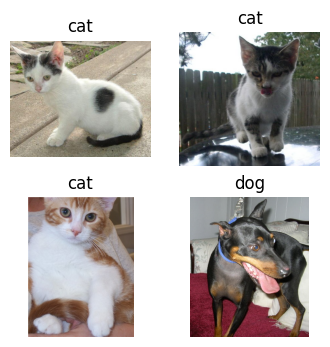

In [ ]:
create_img_grid("/content/drive/MyDrive/Colab_data/cat_dog/train", 4)

## Create a Neural Nets model using a pre-trained model (feature extraction)

**I choose EfficientNetB0**

In [ ]:
def augmentator(data):
  ''' Data augmentation layer of the model'''

  augmentation_layer = tf.keras.Sequential([
      tf.keras.layers.RandomSaturation((0,1)),
      tf.keras.layers.RandomRotation(0.1)
  ])
  return augmentation_layer(data)

def efficientNetB0_plus(img_size):
  ''' A binary classification neural networks based on EfficientNetB0 '''
  inputs = tf.keras.Input(shape=img_size)
  x = augmentator(inputs)
  effNet = tf.keras.applications.EfficientNetB0(include_top=False,
                                                weights='imagenet',
                                                input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
  effNet.trainable = False
  x = effNet(x, training = False)
  #
  global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()
  x = global_avg_pooling(x)
  #
  prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
# Declaring an instance of the model
effnet_plus = efficientNetB0_plus((IMG_HEIGHT, IMG_WIDTH, CHANNELS))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Compiling the model
effnet_plus.compile(loss = tf.keras.losses.BinaryCrossentropy,
                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
                    metrics = ['accuracy'])

In [ ]:
# Declaring an EarlyStopping callback.
# This when called in fit(), stops the model when the loss of the validation set doesn't improve
earlystopping = tf.keras.callbacks.EarlyStopping()

In [ ]:
# Train the model
history_binary_effnet = effnet_plus.fit(train_data, epochs=50, validation_data=test_data, callbacks=[earlystopping])

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.5312 - loss: 1.0173 - val_accuracy: 0.7812 - val_loss: 0.6066
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.5000 - loss: 0.7992 - val_accuracy: 0.7812 - val_loss: 0.6011
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.6562 - loss: 0.6156 - val_accuracy: 0.8125 - val_loss: 0.5952
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5625 - loss: 0.6892 - val_accuracy: 0.8125 - val_loss: 0.5891
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6562 - loss: 0.6535 - val_accuracy: 0.8125 - val_loss: 0.5828
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.6250 - loss: 1.0560 - val_accuracy: 0.8125 - val_loss: 0.5793
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6875 - loss: 2.8577 - val_accuracy: 0.8125 - val_loss: 0.5765
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5938 - loss: 0.6399 - val_accuracy: 0.8125 - val_loss: 0.5736
Epoch 9/50

In [ ]:
def plot_history(tf_history):
  ''' Plot loss and accuracy history for a model using Tensorflow history '''
  # Loss
  plt.figure()
  plt.plot(tf_history.epoch, tf_history.history['loss'], label='train')
  plt.plot(tf_history.epoch, tf_history.history['val_loss'], label = 'validation')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  # Accuracy
  plt.figure()
  plt.plot(tf_history.epoch, tf_history.history['accuracy'], label='train')
  plt.plot(tf_history.epoch, tf_history.history['val_accuracy'], label = 'validation')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

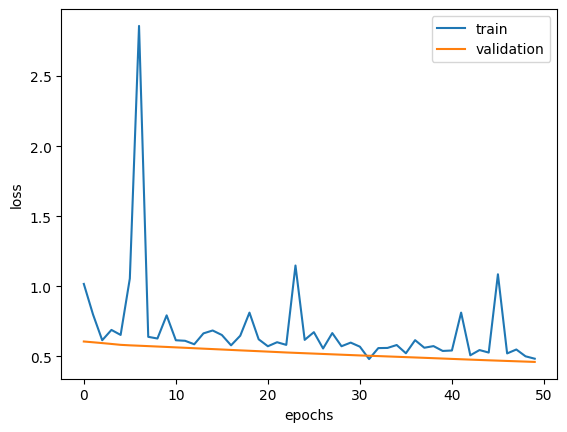

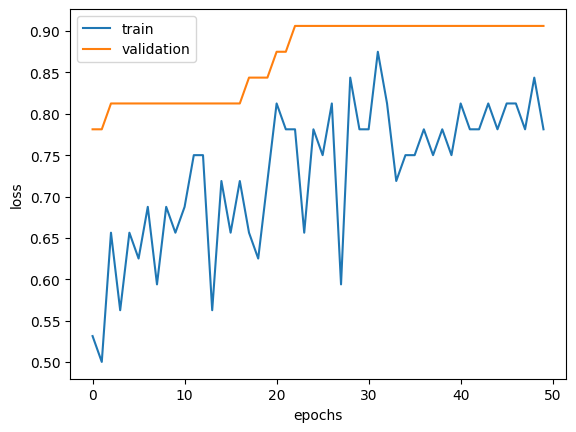

In [ ]:
plot_history(history_binary_effnet)

**I am not quite sure why I get such a noisy training. I lowered the learning rate in case we are overshooting but did not improve the noisiness**

## Final test on random images of Wikipedia

In [ ]:
!wget -O dog.jpg "https://upload.wikimedia.org/wikipedia/commons/7/7a/Huskiesatrest.jpg"

--2025-03-17 22:37:37--  https://upload.wikimedia.org/wikipedia/commons/7/7a/Huskiesatrest.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4854901 (4.6M) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]   4.63M  28.0MB/s    in 0.2s    

2025-03-17 22:37:37 (28.0 MB/s) - ‘dog.jpg’ saved [4854901/4854901]



In [ ]:
image = tf.keras.utils.load_img("/content/dog.jpg", target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb')
img_arr = tf.keras.utils.img_to_array(image)
test_img = np.array([img_arr])  # Convert single image to a batch.

In [ ]:
y_pred = effnet_plus.predict(test_img)
print(f"The model predicts:{class_names[int(np.round(y_pred.flatten()[0]))]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
The model predicts:cat


**Very Interesting! So I intentionally picked the huskie image because suspected that the ears might through the model off. And I guess I was right! Let's see how it does on a different dog image:**

In [ ]:
!wget -O dog1.jpg 'https://upload.wikimedia.org/wikipedia/commons/9/99/Brooks_Chase_Ranger_of_Jolly_Dogs_Jack_Russell.jpg'

--2025-03-17 23:43:04--  https://upload.wikimedia.org/wikipedia/commons/9/99/Brooks_Chase_Ranger_of_Jolly_Dogs_Jack_Russell.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628799 (614K) [image/jpeg]
Saving to: ‘dog1.jpg’

dog1.jpg            100%[===================>] 614.06K  --.-KB/s    in 0.03s   

2025-03-17 23:43:04 (22.7 MB/s) - ‘dog1.jpg’ saved [628799/628799]



In [ ]:
image = tf.keras.utils.load_img("/content/dog1.jpg", target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb')
img_arr = tf.keras.utils.img_to_array(image)
test_img1 = np.array([img_arr])  # Convert single image to a batch.

In [ ]:
y_pred = effnet_plus.predict(test_img1)
print(f"The model predicts:{class_names[int(np.round(y_pred.flatten()[0]))]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
The model predicts:dog


**Ok so my hypothesis that the ears were probably througing the model off might be right**

**As a final test, let's try an image of a cat**

In [ ]:
!wget -O cat.jpg "https://upload.wikimedia.org/wikipedia/commons/2/25/Siam_lilacpoint.jpg"

--2025-03-18 00:14:23--  https://upload.wikimedia.org/wikipedia/commons/2/25/Siam_lilacpoint.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 647001 (632K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 631.84K  --.-KB/s    in 0.03s   

2025-03-18 00:14:23 (22.1 MB/s) - ‘cat.jpg’ saved [647001/647001]



In [ ]:
image = tf.keras.utils.load_img("/content/cat.jpg", target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb')
img_arr = tf.keras.utils.img_to_array(image)
test_img2 = np.array([img_arr])  # Convert single image to a batch.

In [ ]:
y_pred = effnet_plus.predict(test_img2)
print(f"The model predicts:{class_names[int(np.round(y_pred.flatten()[0]))]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
The model predicts:cat


In [ ]:
EXCELE